In [16]:
!git clone https://github.com/perrying/guided-filter-pytorch.git

fatal: destination path 'guided-filter-pytorch' already exists and is not an empty directory.


In [17]:
!ls -l guided-filter-pytorch

total 32
-rw-r--r-- 1 root root  670 Jun 22 13:32 boxfilter.py
-rw-r--r-- 1 root root 2304 Jun 22 13:32 demo.py
-rw-r--r-- 1 root root 6332 Jun 22 13:32 guided_filter.py
-rw-r--r-- 1 root root 1070 Jun 22 13:32 LICENSE
drwxr-xr-x 2 root root 4096 Jun 22 13:32 __pycache__
-rw-r--r-- 1 root root  691 Jun 22 13:32 README.md
drwxr-xr-x 2 root root 4096 Jun 22 13:32 sample_images


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

In [19]:
sys.path.append('/kaggle/working/guided-filter-pytorch')
from guided_filter import GuidedFilter2d  # Import GuidedFilter2d
from boxfilter import boxfilter2d

In [20]:
# class DeepCrackLoss(nn.Module):
#     def __init__(self, weight_pos=None, weight_neg=1.0):
#         super(DeepCrackLoss, self).__init__()
#         self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
#         self.weight_neg = weight_neg
#         # Tính C0 và C1 từ dataset
#         total_pixels = 0
#         total_pos = 0
#         for _, labels in train_loader:  # Giả sử train_loader đã được định nghĩa
#             total_pixels += labels.numel()
#             total_pos += labels.sum().item()
#         self.weight_pos = (total_pixels - total_pos) / total_pos if weight_pos is None else weight_pos
#         self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

#     def forward(self, outputs, targets):
#         total_loss = 0.0
#         # Tính Lside cho 5 side outputs
#         for i, output in enumerate(outputs[:-1]):
#             output_crack = output[:, 1, :, :].unsqueeze(1)  # Đảm bảo shape [batch, 1, h, w]
#             pos_weight = torch.sum(targets) / (targets.numel() - torch.sum(targets) + 1e-6) * self.weight_pos
#             neg_weight = (1 - torch.sum(targets) / (targets.numel() + 1e-6)) * self.weight_neg
#             weights = torch.where(targets > 0, pos_weight, neg_weight).to(device)
#             bce = self.bce_loss(output_crack, targets.float())
#             weighted_loss = bce * weights
#             alpha_m = 0.5 + 0.1 * i if i < 4 else 0.5  # Trọng số động
#             total_loss += alpha_m * weighted_loss.mean()

#         # Tính Lfuse cho fused output
#         fused_output = outputs[-1]
#         fused_crack = fused_output[:, 1, :, :].unsqueeze(1)
#         pos_weight_fused = torch.sum(targets) / (targets.numel() - torch.sum(targets) + 1e-6) * self.weight_pos
#         neg_weight_fused = (1 - torch.sum(targets) / (targets.numel() + 1e-6)) * self.weight_neg
#         weights_fused = torch.where(targets > 0, pos_weight_fused, neg_weight_fused).to(device)
#         bce_fused = self.bce_loss(fused_crack, targets.float())
#         fused_loss = bce_fused * weights_fused
#         total_loss += fused_loss.mean()

#         # Thêm loss từ guided filtering
#         guide = fused_crack
#         guided_fused = self.guided_filter(fused_output, guide)
#         bce_guided = self.bce_loss(guided_fused, targets.float())
#         guided_loss = (bce_guided * weights_fused).mean()
#         total_loss += 0.5 * guided_loss

#         return total_loss

In [21]:
# class DeepCrackLoss(nn.Module):
#     def __init__(self, weight_pos=None, weight_neg=1.0):
#         super(DeepCrackLoss, self).__init__()
#         self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
#         self.weight_neg = weight_neg
#         total_pixels = 0
#         total_pos = 0
#         for _, labels in train_loader:
#             total_pixels += labels.numel()
#             total_pos += labels.sum().item()
#         self.weight_pos = (total_pixels - total_pos) / total_pos if weight_pos is None else weight_pos
#         self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

#     def forward(self, outputs, targets):
#         total_loss = 0.0
#         for i, output in enumerate(outputs[:-1]):
#             output_crack = output  # Đã là 1 kênh
#             pos_weight = torch.sum(targets) / (targets.numel() - torch.sum(targets) + 1e-6) * self.weight_pos
#             neg_weight = (1 - torch.sum(targets) / (targets.numel() + 1e-6)) * self.weight_neg
#             weights = torch.where(targets > 0, pos_weight, neg_weight).to(device)
#             bce = self.bce_loss(output_crack, targets.float())
#             weighted_loss = bce * weights
#             alpha_m = 0.5 + 0.1 * i if i < 4 else 0.5
#             total_loss += alpha_m * weighted_loss.mean()

#         fused_output = outputs[-1]
#         pos_weight_fused = torch.sum(targets) / (targets.numel() - torch.sum(targets) + 1e-6) * self.weight_pos
#         neg_weight_fused = (1 - torch.sum(targets) / (targets.numel() + 1e-6)) * self.weight_neg
#         weights_fused = torch.where(targets > 0, pos_weight_fused, neg_weight_fused).to(device)
#         bce_fused = self.bce_loss(fused_output, targets.float())
#         fused_loss = bce_fused * weights_fused
#         total_loss += fused_loss.mean()

#         guide = fused_output
#         guided_fused = self.guided_filter(fused_output, guide)
#         bce_guided = self.bce_loss(guided_fused, targets.float())
#         guided_loss = (bce_guided * weights_fused).mean()
#         total_loss += 0.5 * guided_loss

#         return total_loss

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=1.8, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Trọng số cho lớp crack
        self.gamma = gamma  # Tham số điều chỉnh độ tập trung
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)  # Xác suất dự đoán đúng
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'none':
            return F_loss
        elif self.reduction == 'mean':
            return F_loss.mean()
        return F_loss.sum()

class DeepCrackLoss(nn.Module):
    def __init__(self):
        super(DeepCrackLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=0.75, gamma=1.8, reduction='none')
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def forward(self, outputs, targets):
        total_loss = 0.0
        for i, output in enumerate(outputs[:-1]):
            focal = self.focal_loss(output, targets)
            alpha_m = 0.5 + 0.1 * i if i < 4 else 0.5
            total_loss += alpha_m * focal.mean()  # Tính trung bình loss

        fused_output = outputs[-1]
        focal_fused = self.focal_loss(fused_output, targets)  # Tính Focal Loss cho fused output
        total_loss += focal_fused.mean()

        guide = fused_output
        guided_fused = self.guided_filter(fused_output, guide)
        focal_guided = self.focal_loss(guided_fused, targets)  # Tính Focal Loss cho guided fused
        total_loss += 0.5 * focal_guided.mean()

        return total_loss

In [23]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = (mask > 0.5).long()  # Giữ nguyên shape [1, height, width]
        return image, mask  # Trả về mask với shape [1, height, width]

In [24]:
# normalize
def get_norm_layer(norm_type='batch'):
    if norm_type == 'batch':
        return nn.BatchNorm2d
    raise NotImplementedError('Normalization layer [%s] is not implemented' % norm_type)

# network weight
def init_net(net, init_type='xavier', init_gain=0.02, gpu_ids=[]):
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net = net.cuda()
        net = nn.DataParallel(net, gpu_ids)
    return net

In [25]:
!cat /kaggle/working/guided-filter-pytorch/guided_filter.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from boxfilter import boxfilter2d

class GuidedFilter2d(nn.Module):
    def __init__(self, radius: int, eps: float):
        super().__init__()
        self.r = radius
        self.eps = eps

    def forward(self, x, guide):
        if guide.shape[1] == 3:
            return guidedfilter2d_color(guide, x, self.r, self.eps)
        elif guide.shape[1] == 1:
            return guidedfilter2d_gray(guide, x, self.r, self.eps)
        else:
            raise NotImplementedError

class FastGuidedFilter2d(GuidedFilter2d):
    """Fast guided filter"""
    def __init__(self, radius: int, eps: float, s: int):
        super().__init__(radius, eps)
        self.s = s

    def forward(self, x, guide):
        if guide.shape[1] == 3:
            return guidedfilter2d_color(guide, x, self.r, self.eps, self.s)
        elif guide.shape[1] == 1:
            return guidedfilter2d_gray(guide, x, self.r, self.eps, self.s)
        else:
   

### upsampling bilinear

In [26]:
# class DeepCrackNet(nn.Module):
#     def __init__(self, in_nc=3, num_classes=1, ngf=64, norm='batch'):  # Sửa num_classes=1
#         super(DeepCrackNet, self).__init__()
#         norm_layer = get_norm_layer(norm_type=norm)
#         self.conv1 = nn.Sequential(*self._conv_block(in_nc, ngf, norm_layer, num_block=2))
#         self.side_conv1 = nn.Conv2d(ngf, num_classes, kernel_size=1, stride=1, bias=False) # conv 1x1 tao ra side output
#         self.conv2 = nn.Sequential(*self._conv_block(ngf, ngf*2, norm_layer, num_block=2))
#         self.side_conv2 = nn.Conv2d(ngf*2, num_classes, kernel_size=1, stride=1, bias=False)
#         self.conv3 = nn.Sequential(*self._conv_block(ngf*2, ngf*4, norm_layer, num_block=3))
#         self.side_conv3 = nn.Conv2d(ngf*4, num_classes, kernel_size=1, stride=1, bias=False)
#         self.conv4 = nn.Sequential(*self._conv_block(ngf*4, ngf*8, norm_layer, num_block=3))
#         self.side_conv4 = nn.Conv2d(ngf*8, num_classes, kernel_size=1, stride=1, bias=False)
#         self.conv5 = nn.Sequential(*self._conv_block(ngf*8, ngf*8, norm_layer, num_block=3))
#         self.side_conv5 = nn.Conv2d(ngf*8, num_classes, kernel_size=1, stride=1, bias=False)
#         self.fuse_conv = nn.Conv2d(num_classes*5, num_classes, kernel_size=1, stride=1, bias=False)
#         self.maxpool = nn.MaxPool2d(2, stride=2)
#         self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

#     def _conv_block(self, in_nc, out_nc, norm_layer, num_block=2, kernel_size=3, stride=1, padding=1, bias=False):
#         conv = []
#         for i in range(num_block):
#             cur_in_nc = in_nc if i == 0 else out_nc
#             conv += [nn.Conv2d(cur_in_nc, out_nc, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
#                      norm_layer(out_nc),
#                      nn.ReLU(True)]
#         return conv

#     def forward(self, x):
#         h, w = x.size()[2:]
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(self.maxpool(conv1))
#         conv3 = self.conv3(self.maxpool(conv2))
#         conv4 = self.conv4(self.maxpool(conv3))
#         conv5 = self.conv5(self.maxpool(conv4))
#         side_output1 = self.side_conv1(conv1)
#         side_output2 = self.side_conv2(conv2)
#         side_output3 = self.side_conv3(conv3)
#         side_output4 = self.side_conv4(conv4)
#         side_output5 = self.side_conv5(conv5)
#         side_output2 = F.interpolate(side_output2, size=(h, w), mode='bilinear', align_corners=True)
#         side_output3 = F.interpolate(side_output3, size=(h, w), mode='bilinear', align_corners=True)
#         side_output4 = F.interpolate(side_output4, size=(h, w), mode='bilinear', align_corners=True)
#         side_output5 = F.interpolate(side_output5, size=(h, w), mode='bilinear', align_corners=True)
#         fused = self.fuse_conv(torch.cat([side_output1, side_output2, side_output3, side_output4, side_output5], dim=1))
#         guide = side_output1  # Sử dụng toàn bộ side_output1 làm guidance
#         guided_fused = self.guided_filter(fused, guide)
#         if self.training:
#             return [side_output1, side_output2, side_output3, side_output4, side_output5, guided_fused]
#         else:
#             prob = torch.sigmoid(guided_fused)  # Sử dụng sigmoid cho nhị phân
#             return prob

### upsampling tranpose conv

In [27]:
class DeepCrackNet(nn.Module):
    def __init__(self, in_nc=3, num_classes=1, ngf=64, norm='batch'):
        super(DeepCrackNet, self).__init__()
        norm_layer = get_norm_layer(norm_type=norm)
        self.conv1 = nn.Sequential(*self._conv_block(in_nc, ngf, norm_layer, num_block=2))
        self.side_conv1 = nn.Conv2d(ngf, num_classes, kernel_size=1, stride=1, bias=False)

        self.conv2 = nn.Sequential(*self._conv_block(ngf, ngf*2, norm_layer, num_block=2))
        self.side_conv2 = nn.Conv2d(ngf*2, num_classes, kernel_size=1, stride=1, bias=False)

        self.conv3 = nn.Sequential(*self._conv_block(ngf*2, ngf*4, norm_layer, num_block=3))
        self.side_conv3 = nn.Conv2d(ngf*4, num_classes, kernel_size=1, stride=1, bias=False)

        self.conv4 = nn.Sequential(*self._conv_block(ngf*4, ngf*8, norm_layer, num_block=3))
        self.side_conv4 = nn.Conv2d(ngf*8, num_classes, kernel_size=1, stride=1, bias=False)

        self.conv5 = nn.Sequential(*self._conv_block(ngf*8, ngf*8, norm_layer, num_block=3))
        self.side_conv5 = nn.Conv2d(ngf*8, num_classes, kernel_size=1, stride=1, bias=False)

        # Transposed convolutions for upsampling
        self.deconv2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=8, stride=4, padding=2, bias=False)
        self.deconv4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
        self.deconv5 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8, bias=False)

        self.fuse_conv = nn.Conv2d(num_classes * 5, num_classes, kernel_size=1, stride=1, bias=False)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def _conv_block(self, in_nc, out_nc, norm_layer, num_block=2, kernel_size=3, stride=1, padding=1, bias=False):
        conv = []
        for i in range(num_block):
            cur_in_nc = in_nc if i == 0 else out_nc
            conv += [nn.Conv2d(cur_in_nc, out_nc, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                     norm_layer(out_nc),
                     nn.ReLU(True)]
        return conv

    def forward(self, x):
        h, w = x.size()[2:]
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.maxpool(conv1))
        conv3 = self.conv3(self.maxpool(conv2))
        conv4 = self.conv4(self.maxpool(conv3))
        conv5 = self.conv5(self.maxpool(conv4))

        side_output1 = self.side_conv1(conv1)
        side_output2 = self.deconv2(self.side_conv2(conv2))
        side_output3 = self.deconv3(self.side_conv3(conv3))
        side_output4 = self.deconv4(self.side_conv4(conv4))
        side_output5 = self.deconv5(self.side_conv5(conv5))

        fused = self.fuse_conv(torch.cat([side_output1, side_output2, side_output3, side_output4, side_output5], dim=1))
        guide = side_output1
        guided_fused = self.guided_filter(fused, guide)

        if self.training:
            return [side_output1, side_output2, side_output3, side_output4, side_output5, guided_fused]
        else:
            prob = torch.sigmoid(guided_fused)
            return prob


In [28]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

In [29]:
train_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/label', 
                             image_transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/label', 
                           image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    best_iou = 0.0
    patience_counter = 0
    patience = 15
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}')

        model.eval()
        total_iou = 0.0
        num_batches = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                best_iou_batch = 0.0
                best_threshold = 0.5
                for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
                    pred = (outputs > threshold).float()
                    intersection = (pred * labels).sum()
                    union = pred.sum() + labels.sum() - intersection
                    iou = intersection / (union + 1e-6)
                    if iou.item() > best_iou_batch:
                        best_iou_batch = iou.item()
                        best_threshold = threshold
                print(f'Best Threshold: {best_threshold}, Best IoU: {best_iou_batch:.4f}')
                total_iou += best_iou_batch
                num_batches += 1
                break
        
        avg_iou = total_iou / num_batches
        print(f'Validation IoU: {avg_iou:.4f}')
        if avg_iou > best_iou:
            best_iou = avg_iou
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

def visualize_results(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            best_threshold = 0.5
            pred = (outputs > best_threshold).float()
            plt.figure(figsize=(15, 5))
            plt.subplot(131)
            plt.imshow(images[0].cpu().permute(1, 2, 0))
            plt.title('Input Image')
            plt.subplot(132)
            plt.imshow(labels[0].cpu().squeeze(), cmap='gray')
            plt.title('Ground Truth')
            plt.subplot(133)
            plt.imshow(pred[0].cpu().squeeze(), cmap='gray')
            plt.title(f'Prediction (Threshold {best_threshold})')
            plt.show()
            break

Epoch 1/100, Average Loss: 0.1332
Best Threshold: 0.4, Best IoU: 0.4897
Validation IoU: 0.4897
Epoch 2/100, Average Loss: 0.0766
Best Threshold: 0.4, Best IoU: 0.5179
Validation IoU: 0.5179
Epoch 3/100, Average Loss: 0.0718
Best Threshold: 0.5, Best IoU: 0.4459
Validation IoU: 0.4459
Epoch 4/100, Average Loss: 0.0699
Best Threshold: 0.5, Best IoU: 0.4985
Validation IoU: 0.4985
Epoch 5/100, Average Loss: 0.0672
Best Threshold: 0.4, Best IoU: 0.4914
Validation IoU: 0.4914
Epoch 6/100, Average Loss: 0.0653
Best Threshold: 0.4, Best IoU: 0.5013
Validation IoU: 0.5013
Epoch 7/100, Average Loss: 0.0646
Best Threshold: 0.4, Best IoU: 0.5162
Validation IoU: 0.5162
Epoch 8/100, Average Loss: 0.0613
Best Threshold: 0.4, Best IoU: 0.4900
Validation IoU: 0.4900
Epoch 9/100, Average Loss: 0.0626
Best Threshold: 0.4, Best IoU: 0.4346
Validation IoU: 0.4346
Epoch 10/100, Average Loss: 0.0622
Best Threshold: 0.4, Best IoU: 0.5012
Validation IoU: 0.5012
Epoch 11/100, Average Loss: 0.0606
Best Threshold

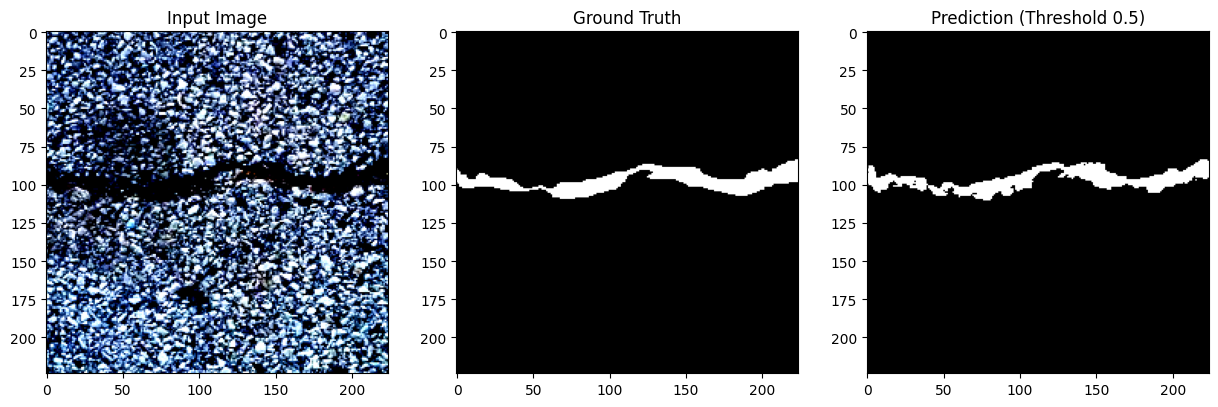

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCrackNet().to(device)
model = init_net(model, init_type='xavier', init_gain=0.02, gpu_ids=[0] if torch.cuda.is_available() else [])
criterion = DeepCrackLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 100
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
visualize_results(model, val_loader, device)